# Best practices

In this notebook we go through some more opinionated best practices, if starting a project from scratch this may be informative for setting things up to be probabilistic.

## Line fitting

 This minimal example demonstrates Bayesian parameter estimation for a simple linear model using adaptive nested sampling. Synthetic data is generated from a linear model with parameters for slope, intercept, and noise level. The example sets up the likelihood and uniform priors, samples the posterior using blackJAX's nested sampling routine, and finally post-processes the samples with the `anesthetic` package for in-depth visualization and analysis.

### Installation

In [7]:
!pip install -q git+https://github.com/handley-lab/blackjax anesthetic tqdm

/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [8]:
import jax
import jax.numpy as jnp
import tqdm
import blackjax

When debugging, and in general when encountering many issues, forcing jax to use double precision is a good idea. Note however, if you want things to be as fast as possible, single is much better, it is worth trying!

In [9]:
jax.config.update("jax_enable_x64", True)

### Nested Sampling parameters
 
 - `num_dims` is the number of parameters you are fitting for
 - `num_live` is a resolution parameter. evidence and posteriors get better as sqrt(nlive), runtime increases linearly with num_live 
 - `num_inner_steps` is a reliability parameter. Setting this too low degrades results, but there is no gain to arbitrarily increasing it. Best practice is to check that halving or doubling it doesn't change the results. runtime increases linearly with num_inner_steps
 - `num_delete` is a parallelisation parameter. You shouldn't need to change this.

In [10]:
rng_key = jax.random.PRNGKey(0)
num_dims = 3
num_live = 1000
num_inner_steps = num_dims * 5
num_delete = num_live // 2

### Define data and likelihood
 
 This problem consists of fitting a `y=mx+c` model to data, where the gradient `m`, intercept `c` and noise level `sigma` are to be fitted for from a set of (x, y) data points.
 In this instance the true model has $m=2, c=1, \sigma=1$.

In [11]:
num_data = 10
xmin, xmax = -1.0, 1.0
x = jnp.linspace(xmin, xmax, num_data)
m = 2.0
c = 1.0
sigma = 1
key, rng_key = jax.random.split(rng_key)
noise = sigma * jax.random.normal(key, (num_data,)) 
y = m * x + c + noise

Easiest just to plot the data to see.

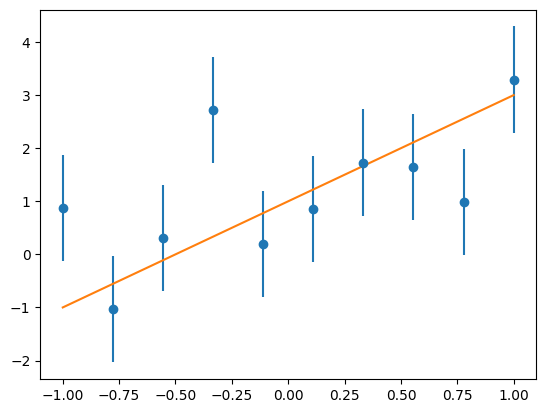

In [12]:
import matplotlib.pyplot as plt

plt.errorbar(x, y, yerr=sigma, fmt="o", label="data")
plt.plot(x, m * x + c, label="true model");

## Structured Prior Models

BlackJAX's nested sampling implementation encourages the use of structured parameter spaces through dictionaries (PyTrees). This is the **recommended pattern** for several important reasons:

1. **Parameter naming**: Clear, semantic names for each parameter make your model self-documenting
2. **Heterogeneous types**: Different parameters can have different shapes and structures  
3. **JAX compatibility**: Dictionary structures are first-class PyTrees in JAX, enabling automatic differentiation and vectorization
4. **Extensibility**: Adding new parameters is as simple as adding a new dictionary key

In this example we'll use a dictionary with keys `"m"`, `"c"`, and `"sigma"` rather than a flat array like `params[0]`, `params[1]`, `params[2]`. This structured approach:
- Makes the likelihood function readable: `params["m"]` vs `params[0]`
- Simplifies prior specification with per-parameter bounds
- Enables easy parameter transformations and constraints
- Facilitates integration with other probabilistic programming tools

The `blackjax.ns.utils.uniform_prior` helper we'll use later automatically creates this structured format from a bounds dictionary.

###  Define the likelihood function

 Here we just make use of the `scipy` multivariate normal distribution to define the likelihood function, which is normal in the data.

In [13]:
def loglikelihood_fn(params):
    m = params["m"]
    c = params["c"]
    sigma = params["sigma"]
    cov = sigma ** 2
    return jax.scipy.stats.multivariate_normal.logpdf(y, m * x + c, cov)

### Define the prior function

 Here we use uniform priors for the parameters.

In [14]:
prior_bounds = {
        "m": (-5.0, 5.0),
        "c": (-5.0, 5.0),
        "sigma": (0.0, 10.0),
        }

rng_key, prior_key = jax.random.split(rng_key)
particles, logprior_fn = blackjax.ns.utils.uniform_prior(prior_key, num_live, prior_bounds)

In [15]:
print(f"Particle structure: {particles.keys()}")
print(f"Shape of each parameter: {particles['m'].shape}")
print(f"First few samples of 'm': {particles['m'][:3]}")

Particle structure: dict_keys(['c', 'm', 'sigma'])
Shape of each parameter: (1000,)
First few samples of 'm': [-0.46275406 -1.23704798  3.88207402]


As you can see, `particles` is a dictionary where each key corresponds to a parameter, and the values are arrays of shape `(num_live,)` containing the initial samples for that parameter. This structure propagates through the entire nested sampling run, making it easy to track and analyze individual parameters throughout the algorithm.

## Run Nested Sampling

In [16]:
nested_sampler = blackjax.nss(
    logprior_fn=logprior_fn,
    loglikelihood_fn=loglikelihood_fn,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps,
)
init_fn = jax.jit(nested_sampler.init)
step_fn = jax.jit(nested_sampler.step)

live = init_fn(particles)
dead = []
with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not live.logZ_live - live.logZ < -3:
        rng_key, subkey = jax.random.split(rng_key, 2)
        live, dead_info = step_fn(subkey, live)
        dead.append(dead_info)
        pbar.update(num_delete)

dead = blackjax.ns.utils.finalise(live, dead)

Dead points: 7500 dead points [00:00, 9159.53 dead points/s] 


### Save the data as a csv

 This uses the anesthetic tool, a nested sampler agnostic software package for processing and plotting nested sampling results (think getdist, arviz, corner.py, but specialised for nested sampling). 

 You may prefer other posterior plotting packages, but should be aware of this for the nested sampling specific pieces, including but not limited to:
 - `samples.logZ()` - the log evidence
 - `samples.logZ(n)` - samples from the evidence distribution
 - `samples.gui()` - a GUI for exploring the nested sampling run
    - also accessible as an executable `anesthetic line.csv` if you've saved the samples.
 - `samples.prior()` - the prior samples
 - `samples.live_points(i)` - the live points at any point in the run

In [17]:
from anesthetic import NestedSamples
labels = {
    "m": r"$m$",
    "c": r"$c$",
    "sigma": r"$\sigma$"
}

samples = NestedSamples(
    dead.particles,
    logL=dead.loglikelihood,
    logL_birth=dead.loglikelihood_birth,
    labels=labels,
)
samples.to_csv("line.csv")

## Plot results

 The rest of this script showcases nested sampling plotting and analysis capabilities

load results from file if you're returning to this script later

In [18]:
from anesthetic import read_chains
samples = read_chains("line.csv")

### Plot the posterior with anesthetic

 For more detail have a look at 
 https://anesthetic.readthedocs.io/en/latest/plotting.html

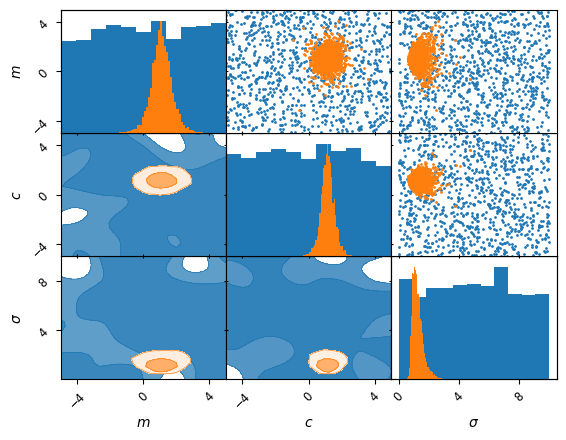

In [19]:
kinds ={'lower': 'kde_2d', 'diagonal': 'hist_1d', 'upper': 'scatter_2d'}
axes = samples.prior().plot_2d(['m', 'c', 'sigma'], kinds=kinds, label='prior')
samples.plot_2d(axes, kinds=kinds, label='posterior');

Plot the functional posterior

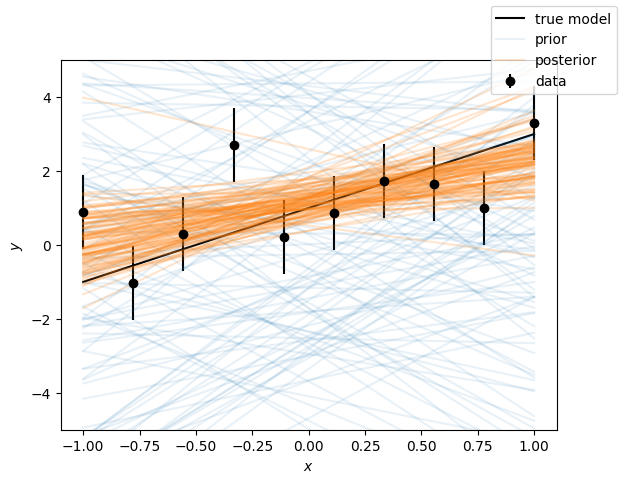

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Plot the data
ax.errorbar(x, y, yerr=sigma, fmt="o", label="data", color='k')
ax.plot(x, m * x + c, label="true model", color='k');

# Get samples from the function y=mx+c
m_ = samples.m.values[:, None]
c_ = samples.c.values[:, None]
y_ = m_ * x  + c_
yvals = [f'y_{i}' for i in range(num_data)]
samples[yvals] = y_

# Plot the prior and posterior function samples
lines = ax.plot(x, samples.prior()[yvals].sample(100).T, color="C0", alpha=0.1)
lines[0].set_label("prior")
lines = ax.plot(x, samples[yvals].sample(100).T, color="C1", alpha=0.2)
lines[0].set_label("posterior")

# tidy up
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_ylim(-5, 5)
fig.legend();

## Structured Priors and probabilistic programming

While the `uniform_prior` helper used above is convenient for simple cases, a more general best practice is to use a unified interface that provides both sampling and log-density evaluation from the same object. This ensures consistency and extends naturally to more complex priors.

It is recommended to use an established probabilistic programming language. We will explore `distrax` in this example, `tensorflow_probability` is another option that is widely used. We will again examine the same problem, but set up a non-trivial prior for our analysis.

In [33]:
import distrax
import jax.numpy as jnp

m_prior = distrax.Normal(loc=0.0, scale=2.0)
c_prior = distrax.Beta(alpha=2.0, beta=2.0)
sigma_prior = distrax.Transformed(
    distrax.Normal(loc=0.0, scale=1.0), distrax.Lambda(lambda x: jnp.exp(x))
)

prior = distrax.Joint({"m": m_prior, "c": c_prior, "sigma": sigma_prior})
rng_key, prior_key = jax.random.split(rng_key)
particles = prior.sample(seed=prior_key, sample_shape=(num_live,))

In [34]:

print(f"Particle structure: {particles.keys()}")
print(f"Shape of each parameter: {particles['m'].shape}")
print(f"First few samples of 'm': {particles['m'][:3]}")

Particle structure: dict_keys(['c', 'm', 'sigma'])
Shape of each parameter: (1000,)
First few samples of 'm': [-0.58214336 -2.98410454  2.54834226]


### Running Nested Sampling again

We could have made this more efficient, but we can largely reuse the nested sampling code from before, noting we have to define our algorithm with this new log_prob

In [35]:
nested_sampler = blackjax.nss(
    logprior_fn=prior.log_prob,
    loglikelihood_fn=loglikelihood_fn,
    num_delete=num_delete,
    num_inner_steps=num_inner_steps,
)
init_fn = jax.jit(nested_sampler.init)
step_fn = jax.jit(nested_sampler.step)

live = init_fn(particles)
dead = []
with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not live.logZ_live - live.logZ < -3:
        rng_key, subkey = jax.random.split(rng_key, 2)
        live, dead_info = step_fn(subkey, live)
        dead.append(dead_info)
        pbar.update(num_delete)

dead = blackjax.ns.utils.finalise(live, dead)

Dead points: 5500 dead points [00:01, 5493.96 dead points/s]


### Visualisation of results

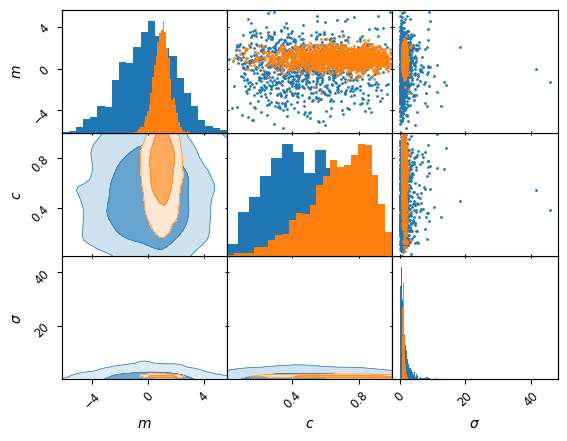

In [36]:
samples = NestedSamples(
    dead.particles,
    logL=dead.loglikelihood,
    logL_birth=dead.loglikelihood_birth,
    labels=labels,
)
kinds ={'lower': 'kde_2d', 'diagonal': 'hist_1d', 'upper': 'scatter_2d'}
axes = samples.prior().plot_2d(['m', 'c', 'sigma'], kinds=kinds, label='prior')
samples.plot_2d(axes, kinds=kinds, label='posterior');

## Trainable bijectors

In part the motivation for using a library like `distrax` is basic consistency, we will now demonstrate that we can gain a lot of flexibility by using these libraries.

We have already used a bijector, a bi-directional mapping that maps from one distribution to another. We will now show a quick demo of using `distrax` as well as the neural network library `flax` and optimization from `optax` to train a flexible bijector. We will use the free-form mapping of a neural network in a RealNVP affine coupling flow, to train a mapping from an arbitrary base distribution to emulate the result of our sampling algorithm. Effectively we can learn a fast surrogate posterior distribution.

In [60]:
import flax.linen as nn
import optax


class MLP(nn.Module):
    features: int
    num_bijector_params: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        # Initialize to zero for identity function
        x = nn.Dense(
            self.features * self.num_bijector_params,
            kernel_init=nn.initializers.zeros,
            bias_init=nn.initializers.zeros,
        )(x)
        return x.reshape(x.shape[:-1] + (self.features, self.num_bijector_params))


def make_flow_model(params, event_size: int, num_layers: int = 4):
    """Creates coupling flow model"""
    # Alternating binary mask
    mask = jnp.arange(event_size) % 2 == 0

    def bijector_fn(params):
        # Simple affine transformation
        shift, log_scale = jnp.split(params, 2, axis=-1)
        log_scale = jnp.tanh(log_scale)  # Bound log_scale
        return distrax.ScalarAffine(shift=shift[..., 0], log_scale=log_scale[..., 0])

    mlp = MLP(features=event_size, num_bijector_params=2)

    def conditioner_fn(x):
        return mlp.apply(params, x)

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask, bijector=bijector_fn, conditioner=conditioner_fn
        )
        layers.append(layer)
        mask = ~mask  # Flip mask

    flow = distrax.Inverse(distrax.Chain(layers))
    base = distrax.MultivariateNormalDiag(
        loc=jnp.zeros(event_size), scale_diag=jnp.ones(event_size)
    )

    return distrax.Transformed(base, flow)

Now we can train this bijection from a base Gaussian to emulate our distribution, we will have to sample from our already acquired posterior samples, and work in $\mathcal{R}^D$ to keep the network happy, so remember to transform back to our tree structure, thankfully `jax` includes some handy utils for this purpose.

In [61]:
from blackjax.ns.utils import log_weights
rng, weight_key = jax.random.split(rng_key)
log_w = log_weights(weight_key, dead).mean(axis=-1)

# Get the ravel function for one particle
sample_tree = {k: v[0] for k, v in dead.particles.items()}
_, unravel_fn = jax.flatten_util.ravel_pytree(sample_tree)

# Convert all samples directly - just stack the arrays in the same order as ravel_pytree
flat_leaves, _ = jax.tree_util.tree_flatten(dead.particles)
N_samples = flat_leaves[0].shape[0]
posterior_samples = jnp.column_stack(flat_leaves)  # (N, 3) array



### Training a neural network

`optax` is the standard for stochastic optimization in `jax`, we will use a basic setup here, 

1. Drawing random batches from the weighted samples produced by Nested Sampling
2. Flatten the space to a vector to pass through the network
3. Use the above RealNVP to apply the transform and compute the mean KL of the batch of points relative to the current state of the flow
4. Update the flow accordingly to minimize this objective and continue

In [63]:
rng, init_key = jax.random.split(rng)
mlp = MLP(features=num_dims, num_bijector_params=2)
params = mlp.init(init_key, jnp.zeros((1, num_dims)))

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

def loss_fn(params, batch):
    model = make_flow_model(params, event_size=num_dims)
    return -jnp.mean(model.log_prob(batch))

@jax.jit
def train_step(params, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

batch_size = min(256, N_samples)
num_steps = 3000

print("Training flow...")
for step in range(num_steps):
    rng, batch_key = jax.random.split(rng)
    # weights = jnp.exp(log_w - jnp.max(log_w))
    idx = jax.random.choice(batch_key, a=N_samples, shape=(batch_size,), replace=False, p=jnp.exp(log_w))
    batch = posterior_samples[idx]
    params, opt_state, loss = train_step(params, opt_state, batch)
    
    if step % 500 == 0:
        print(f"Step {step}: loss = {loss:.4f}")


Training flow...
Step 0: loss = 4.5106
Step 500: loss = 0.7199
Step 1000: loss = 0.6914
Step 1500: loss = 0.6320
Step 2000: loss = 0.7696
Step 2500: loss = 0.6914


### Analysis of the normalizing flow

Now the network is trained, we can draw samples directly from this flow, below we compare a plot of this to the existing training sample. As we can see the bijector has done a good job! In practice this example is so simple that there is limited point, but the same mechanism can be used to train a fast representation of the posterior, if for example the forward model is a super expensive physics simulation.

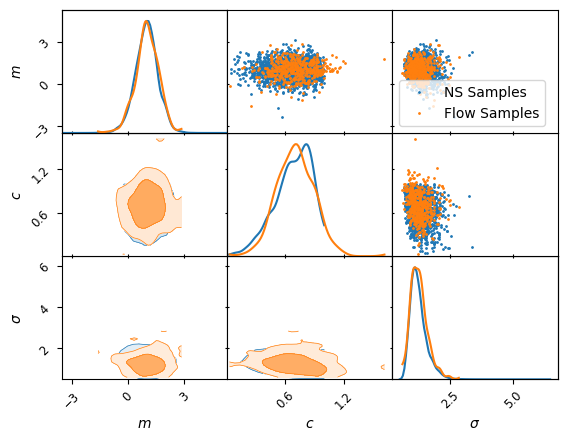

In [64]:
from anesthetic import MCMCSamples

rng, sample_key = jax.random.split(rng)
model = make_flow_model(params, event_size=num_dims)
flow_samples = model.sample(seed=sample_key, sample_shape=(500,))

# Convert flow samples back to dict structure using unravel_fn
flow_samples_dict = jax.vmap(unravel_fn)(flow_samples)

a = NestedSamples(
    dead.particles,
    logL=dead.loglikelihood,
    logL_birth=dead.loglikelihood_birth,
    labels=labels,
).plot_2d(list(labels.keys()),label="NS Samples")
MCMCSamples(
    flow_samples_dict,
    labels=labels,
).plot_2d(a, label="Flow Samples");
plt.legend();
